# MS-263 Final Project
## Exploring the Relation between Temperature and Current Velocity from a Mooring in Stillwater Cove
#### Logan Grady

## Introduction
Monterey Bay, California is well known for many of its unique biological, physical, and geographic features. The main inlet of the bay is home to large submarine canyon that stretches for miles offshore and reaches thousands of meters of depth. Consistent northeasterly winds cause upwelling in Ano Nuevo to the north, Big Sur to the south, lifting up large concentrations of deep water nutrients that stimulate some of the most productive ecosystems on the planet. Stemming off of the much larger Monterey Canyon, and reaching around the southern side of the Monterey peninsula is the Carmel Canyon, which reaches far inshore of Carmel Bay. While the main inlet of Monterey bay has had much research conducted on the physical processes that govern the patterns of temperature and water movement, less can be said about this smaller inlet south of the peninsula. 

A recent study by Anna Lowe (2020) looked into the circulation patterns of Carmel Bay in order to study the connectivity of larva dispersion in the biologically productive region. This study was conducted using the Regional Ocean Modeling System to simulate circulation in Camrel Bay during the 2014/15 upwelling seasons. The study's extensive analysis found that upwelling from the nearby canyon was weaker than upwelling in locations such as Ano Nuevo and Point Sur, but was able to provide cold, nutrient rich water into the smaller bay. An earleir study conducted by Dustin Carroll in 2009 found similar patterns of deepwater transport from the canyon. Carroll's study concluded that internal waves coming from the Carmel Canyon were able to bring an extra source of nutrients into nearby ecosystems, however locations that were farther on the shelf were not subsidized by the internal waves. 

This project aims to build upon the work of previous studies done in Carmel Bay by looking at an extensive time series of temperature and water velocity data collected by a single mooring placed by PISCO in the 2000, and was pulled out in 2011. This mooring is located in the northern region of the bay in Stillwater Cove. Using the data collected from this mooring, I would like to explore the hydrodynamics of Stillwater Cove and look into how currents and temperature may be related at this location. 

Some potential questions I attempt to answer:
   1. How alongshore and across shore velocity vary with time?
   2. Is there any significant relationship between alongshore/acrosshore velocity and temperature?
   3. What physical features of the water column can be analyzed with the data from this mooring?
   4. How do the physical properties of this location vary seasonally?

# Import all packages

In [1]:
# Basic packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr
import datetime
import os

# Plotting
from matplotlib import pyplot as plt
import matplotlib.colors
import seaborn as sn

# For making maps
import cartopy.crs as ccrs
from maptools import make_map

# Custom functions made for data importation and analysis
import data_prep_functions as dat
import fp_plotting as fpp
import data_analysis as da

# Packages for data analysis
from scipy import stats
from scipy import linalg
from scipy.signal import periodogram
from scipy.signal import welch
from scipy.stats import chi2

# Study Site
The location of the mooring is in Stillwater Cove at a depth of 22 meters. Using the bathymetry data gives a little context into the seafloor environment for this site. The Carmel Canyon runs inshore farther south of Stillwater Cove, however, the effects of upwelling from the canyon can still be detected in this location.

C:\Users\Chili\anaconda\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\Chili\anaconda\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


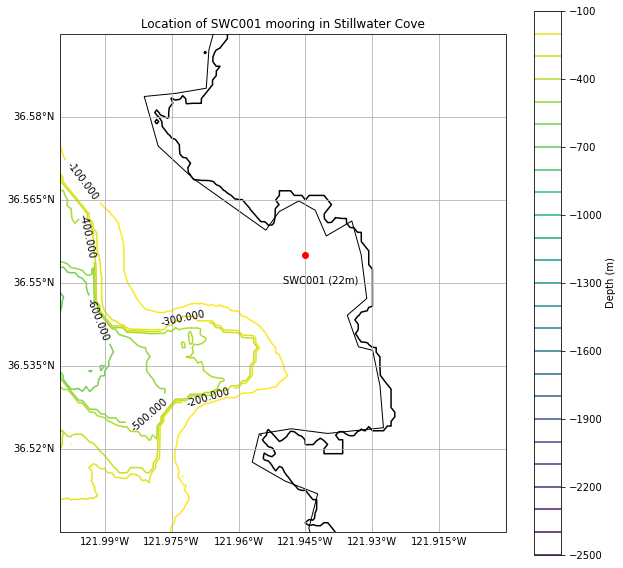

In [2]:
# Load the bathymetry data and convert it into an xarray dataset
bathy_nc = 'coastal_relief_model/crm_vol6_subset.nc'
ds = xr.open_dataset(bathy_nc)

# Create a subset of coordinates to display only Stillwater
dsub = ds.sel(x=slice(-122, -121.9), y=(slice(36.505, 36.595)))

# Plot the map projection with bathymetry contours and location of SWC001 mooring
plt.figure(figsize=(10,10))
ax = make_map(projection = ccrs.Mercator())
ax.set_extent([-122, -121.9, 36.505, 36.595])
cs = plt.contour(dsub['x'], dsub['y'], dsub['z'], np.arange(-2500, 0, 100), transform=ccrs.PlateCarree())
plt.colorbar(label='Depth (m)')
plt.clabel(cs, colors='k')
plt.contour(dsub['x'], dsub['y'], dsub['z'], [0], transform=ccrs.PlateCarree(), colors='k')
plt.plot(-121.945, 36.555, 'ro', transform=ccrs.PlateCarree())
ax.text(-121.95, 36.55, 'SWC001 (22m)', transform=ccrs.PlateCarree())
plt.title('Location of SWC001 mooring in Stillwater Cove')
ax.coastlines()

plt.savefig('mooring_location.PNG')

# Import data

In [3]:
depth = [0,5,13,21]
raw_therm_02 = dat.therm_data_merge('Thermistor', 2002, depth)
therm_02 = dat.therm_pd_to_xr(raw_therm_02, depth)

In [4]:
therm_ref = dat.xr_therm_analysis(therm_02, "1H", 1, 24)
therm_ref

<xarray.Dataset>
Dimensions:               (depth: 4, time: 8737)
Coordinates:
  * time                  (time) datetime64[ns] 2002-01-01 ... 2002-12-31
  * depth                 (depth) int32 0 5 13 21
Data variables:
    temperature           (time, depth) float64 nan nan nan nan ... nan nan nan
    temperature_filtered  (time, depth) float64 nan nan nan nan ... nan nan nan

In [5]:
raw_adcp_02 = dat.adcp_data_merge('ADCP', 2002)
adcp_02 = dat.adcp_pd_to_xr(raw_adcp_02)

In [6]:
adcp_ref = dat.xr_adcp_analysis(adcp_02, "1H", 1, 24)
adcp_ref

<xarray.Dataset>
Dimensions:             (depth: 21, time: 6073)
Coordinates:
  * time                (time) datetime64[ns] 2002-02-21T21:00:00 ... 2002-11...
  * depth               (depth) float64 -0.1 0.9 1.9 2.9 ... 16.9 17.9 18.9 20.9
Data variables:
    northward           (time, depth) float64 nan nan nan ... -0.001368 nan nan
    eastward            (time, depth) float64 nan nan nan ... -0.02779 nan nan
    northward_filtered  (time, depth) float64 nan nan nan nan ... nan nan nan
    eastward_filtered   (time, depth) float64 nan nan nan nan ... nan nan nan
    north_da            (time) float64 nan nan nan nan nan ... nan nan nan nan
    east_da             (time) float64 nan nan nan nan nan ... nan nan nan nan
    alongshore          (time, depth) float64 nan nan nan nan ... nan nan nan
    crossshore          (time, depth) float64 nan nan nan nan ... nan nan nan
    alongshore_da       (time) float64 nan nan nan nan nan ... nan nan nan nan
    crossshore_da       (time) float64 nan nan nan nan nan ... nan nan nan nan

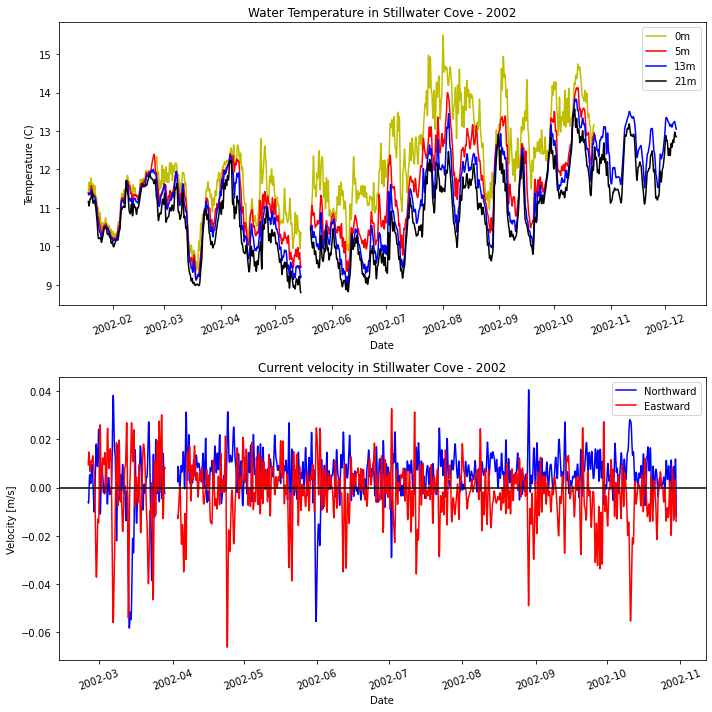

In [7]:
plt.figure(figsize = (10,10))
plt.subplot(211)
plt.plot(therm_ref.time, therm_ref.temperature_filtered.isel(depth=0), '-y')
plt.plot(therm_ref.time, therm_ref.temperature_filtered.isel(depth=1), '-r')
plt.plot(therm_ref.time, therm_ref.temperature_filtered.isel(depth=2), '-b')
plt.plot(therm_ref.time, therm_ref.temperature_filtered.isel(depth=3), '-k')
plt.ylabel('Temperature (C)')
plt.xlabel('Date')
plt.title('Water Temperature in Stillwater Cove - 2002')
plt.xticks(rotation=20)
plt.legend(['0m','5m','13m','21m'])

plt.subplot(212)
plt.plot(adcp_ref.time, adcp_ref.north_da, '-b')
plt.plot(adcp_ref.time, adcp_ref.east_da, '-r')
plt.axhline(y=0,c='k')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Date')
plt.title('Current velocity in Stillwater Cove - 2002')
plt.xticks(rotation=20)
plt.legend(['Northward', 'Eastward'])

plt.tight_layout()
plt.savefig('raw_data_plots.PNG')

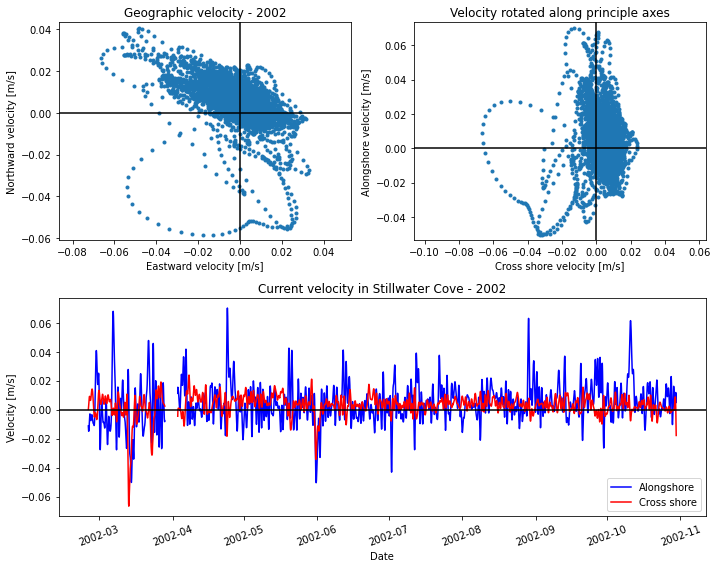

In [8]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(adcp_ref.east_da, adcp_ref.north_da,'.')
plt.axis('equal')
plt.axvline(x=0,c='k')
plt.axhline(y=0,c='k')
plt.xlabel('Eastward velocity [m/s]')
plt.ylabel('Northward velocity [m/s]')
plt.title('Geographic velocity - 2002')

plt.subplot(222)
plt.plot(adcp_ref.crossshore_da, adcp_ref.alongshore_da,'.')
plt.axis('equal')
plt.axvline(x=0,c='k')
plt.axhline(y=0,c='k')
plt.xlabel('Cross shore velocity [m/s]')
plt.ylabel('Alongshore velocity [m/s]')
plt.title('Velocity rotated along principle axes')

plt.subplot(212)
plt.plot(adcp_ref.time, adcp_ref.alongshore_da, '-b')
plt.plot(adcp_ref.time, adcp_ref.crossshore_da, '-r')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Date')
plt.title('Current velocity in Stillwater Cove - 2002')
plt.axhline(y=0,c='k')
plt.xticks(rotation=20)
plt.legend(['Alongshore', 'Cross shore'])

plt.tight_layout()
plt.show
plt.savefig('princax_vectors.PNG')

In [76]:
summer_alongshore = adcp_ref.alongshore.loc["2002-06-01 00:00":"2002-08-30 23:30"]
summer_alongshore = summer_alongshore.isel(depth=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
summer_alongshore = summer_alongshore.dropna('time')
summer_alongshore

<xarray.DataArray 'alongshore' (time: 2184, depth: 15)>
array([[-0.00525644, -0.01041531, -0.01703782, ..., -0.04100515,
        -0.03440371, -0.02568348],
       [-0.0013156 , -0.00732327, -0.01473903, ..., -0.03871013,
        -0.03271947, -0.02445298],
       [ 0.00249384, -0.00445155, -0.01265208, ..., -0.03602063,
        -0.03063406, -0.02287251],
       ...,
       [ 0.00602154,  0.00698182,  0.00878505, ...,  0.03778081,
         0.04147   ,  0.04464742],
       [ 0.0107936 ,  0.01203369,  0.01358084, ...,  0.03788582,
         0.04101387,  0.04391794],
       [ 0.01603451,  0.01737965,  0.01856446, ...,  0.0373447 ,
         0.03984765,  0.04241579]])
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 ... 2002-08-30T23:00:00
  * depth    (depth) float64 3.9 4.9 5.9 6.9 7.9 ... 13.9 14.9 15.9 16.9 17.9

In [77]:
summer_crossshore = adcp_ref.crossshore.loc["2002-06-01 00:00":"2002-08-30 23:30"]
summer_crossshore = summer_crossshore.isel(depth=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
summer_crossshore = summer_crossshore.dropna('time')
summer_crossshore

<xarray.DataArray 'crossshore' (time: 2184, depth: 15)>
array([[-0.00395083, -0.00665415, -0.01079719, ..., -0.0135298 ,
        -0.00926833, -0.00847112],
       [-0.00424344, -0.00658672, -0.01063978, ..., -0.0115069 ,
        -0.00775794, -0.00748104],
       [-0.00486237, -0.00687297, -0.01081526, ..., -0.00960084,
        -0.00630821, -0.00648195],
       ...,
       [ 0.00636   ,  0.00543442,  0.00419603, ..., -0.01498144,
        -0.02071118, -0.02870737],
       [ 0.00481792,  0.00420674,  0.00348614, ..., -0.01471485,
        -0.02065835, -0.0287123 ],
       [ 0.00315742,  0.00290986,  0.00270512, ..., -0.01418441,
        -0.02021305, -0.02820717]])
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 ... 2002-08-30T23:00:00
  * depth    (depth) float64 3.9 4.9 5.9 6.9 7.9 ... 13.9 14.9 15.9 16.9 17.9

In [79]:
summer_therm = therm_ref.temperature_filtered.loc["2002-06-01 00:00":"2002-08-30 23:30"]
summer_therm = summer_therm.dropna('time')
summer_therm

<xarray.DataArray 'temperature_filtered' (time: 2184, depth: 4)>
array([[10.8565943 , 10.76172474, 10.61507428, 10.05276208],
       [10.86387573, 10.76404167, 10.61282859, 10.07600351],
       [10.86889981, 10.76492252, 10.60895839, 10.09790947],
       ...,
       [12.71122791, 12.61797267, 12.59487326, 12.61318569],
       [12.70002051, 12.63025552, 12.60476382, 12.64168049],
       [12.69300796, 12.64480584, 12.61511235, 12.66962935]])
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 ... 2002-08-30T23:00:00
  * depth    (depth) int32 0 5 13 21

In [80]:
as_val, as_val_frac, as_vec, as_fac_load = da.PCA(summer_alongshore)
cs_val, cs_val_frac, cs_vec, cs_fac_load = da.PCA(summer_crossshore)
t_val, t_val_frac, t_vec, t_fac_load = da.PCA(summer_therm)

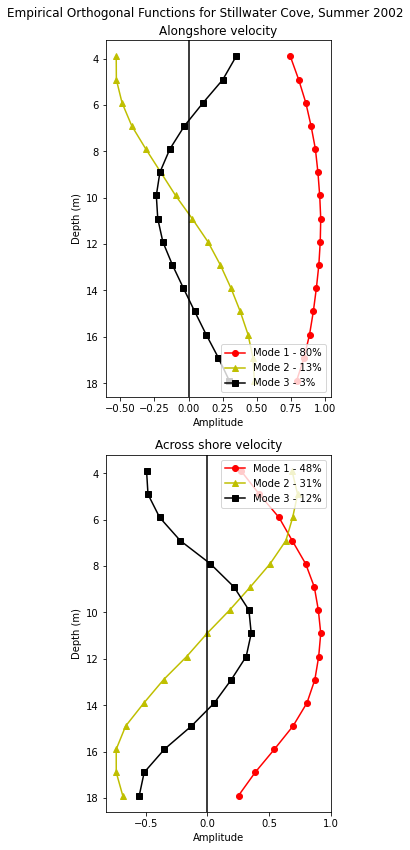

In [88]:
plt.figure(figsize=(4,12))
symbols = ['o-r', '^-y', 's-k']
plt.subplot(211)
variables = ['Mode 1 - ' + str(int(as_val_frac[0])) + '%', 
                 'Mode 2 - ' + str(int(as_val_frac[1])) + '%', 
                 'Mode 3 - ' + str(int(as_val_frac[2])) + '%']
for i,txt in enumerate(variables):
    plt.plot((as_fac_load[:,i])*(-1), summer_alongshore.depth, symbols[i])
plt.axvline(x=0,c='k')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Amplitude')
plt.legend(variables, loc='lower right')
plt.title('Alongshore velocity')

plt.subplot(212)
variables = ['Mode 1 - ' + str(int(cs_val_frac[0])) + '%', 
                 'Mode 2 - ' + str(int(cs_val_frac[1])) + '%', 
                 'Mode 3 - ' + str(int(cs_val_frac[2])) + '%']
for i,txt in enumerate(variables):
    plt.plot(cs_fac_load[:,i], summer_crossshore.depth, symbols[i])
plt.axvline(x=0,c='k')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Amplitude')
plt.legend(variables, loc='upper right')
plt.title('Across shore velocity')
plt.suptitle('Empirical Orthogonal Functions for Stillwater Cove, Summer 2002')

plt.tight_layout()
plt.savefig('EOF_Analysis _velocity.PNG')

<ipython-input-89-93c9c5d9c1a1>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(summer_alongshore.time, summer_alongshore.depth, summer_alongshore.T,norm=norm)
<ipython-input-89-93c9c5d9c1a1>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(summer_crossshore.time, summer_crossshore.depth, summer_crossshore.T,norm=norm)


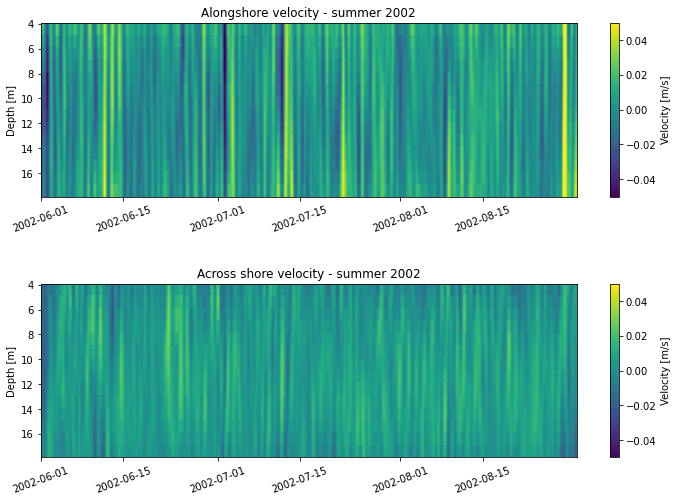

In [89]:
fig = plt.figure(figsize=(12,8))

minvel = -.05
maxvel = .05
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

plt.subplot(2,1,1)
plt.title('Alongshore velocity - summer 2002')
plt.pcolormesh(summer_alongshore.time, summer_alongshore.depth, summer_alongshore.T,norm=norm)
plt.colorbar(label='Velocity [m/s]')
plt.ylabel('Depth [m]')
plt.xticks(rotation='20')
plt.gca().invert_yaxis()

plt.subplot(2,1,2)
plt.title('Across shore velocity - summer 2002')
plt.pcolormesh(summer_crossshore.time, summer_crossshore.depth, summer_crossshore.T,norm=norm)
plt.colorbar(label='Velocity [m/s]')
plt.ylabel('Depth [m]')
plt.xticks(rotation='20')
plt.gca().invert_yaxis()

fig.subplots_adjust(hspace=.5);
plt.savefig('velocity_colorplots.PNG')

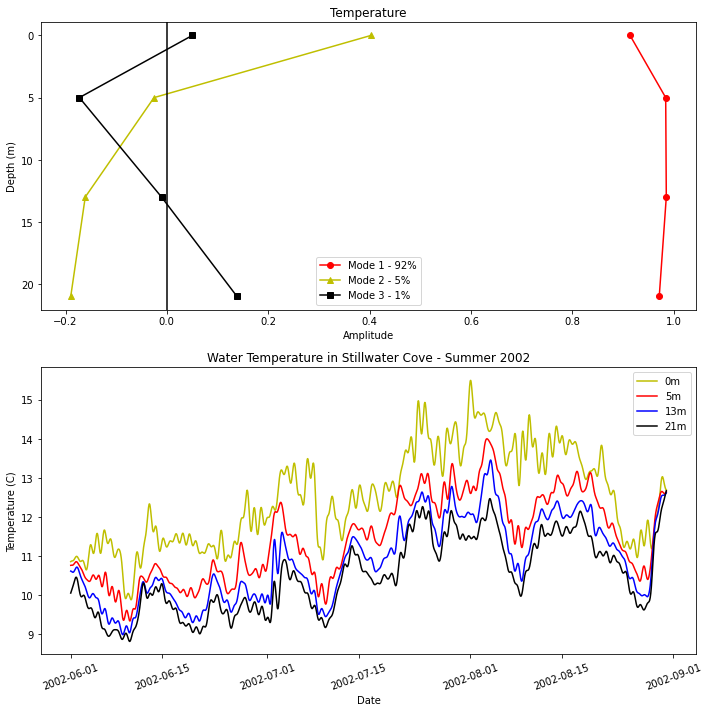

In [90]:
plt.figure(figsize = (10,10))

plt.subplot(211)
variables = ['Mode 1 - ' + str(int(t_val_frac[0])) + '%', 
                 'Mode 2 - ' + str(int(t_val_frac[1])) + '%', 
                 'Mode 3 - ' + str(int(t_val_frac[2])) + '%']
for i,txt in enumerate(variables):
    plt.plot(t_fac_load[:,i], summer_therm.depth, symbols[i])
plt.axvline(x=0,c='k')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Amplitude')
plt.legend(variables, loc='lower center')
plt.title('Temperature')

plt.subplot(212)
plt.plot(summer_therm.time, summer_therm.isel(depth=0), '-y')
plt.plot(summer_therm.time, summer_therm.isel(depth=1), '-r')
plt.plot(summer_therm.time, summer_therm.isel(depth=2), '-b')
plt.plot(summer_therm.time, summer_therm.isel(depth=3), '-k')
plt.ylabel('Temperature (C)')
plt.xlabel('Date')
plt.title('Water Temperature in Stillwater Cove - Summer 2002')
plt.xticks(rotation=20)
plt.legend(['0m','5m','13m','21m'])

plt.tight_layout()
plt.savefig('EOF_Analysis_temp.PNG')

In [154]:
# Multiply the data matrix with the eigenvector matrix to get time series of EOF's

# Alongshore velocity
as_EOF_ts = (np.matmul(summer_alongshore.values, as_vec))*-1

# Cross shore velocity
cs_EOF_ts = np.matmul(summer_crossshore.values, cs_vec)

# Temperature
t_EOF_ts = np.matmul(summer_therm.values, t_vec)

plt.figure(figsize = (20,10))
plt.subplot(321)
plt.plot(summer_alongshore.time, summer_alongshore.isel(depth=8), 'or')
plt.plot(summer_alongshore.time, as_EOF_ts[:,0], '-k')
plt.axhline(y=0, c='k')
plt.xticks(rotation=20)
plt.legend(['Alongshore', 'EOF Mode 1'])

plt.subplot(322)
plt.plot(summer_therm.time, t_EOF_ts[:,0], '-k')
plt.xticks(rotation=20)
plt.title('Mode 1 temperature')

plt.subplot(323)
plt.plot(summer_alongshore.time, as_EOF_ts[:,1], '-b')
plt.plot(summer_crossshore.time, cs_EOF_ts[:,1], '-r')
plt.axhline(y=0, c='k')
plt.xticks(rotation=20)
plt.title('Mode 2 velocity')

plt.subplot(324)
plt.plot(summer_therm.time, t_EOF_ts[:,1], '-k')
plt.xticks(rotation=20)
plt.title('Mode 2 temperature')

plt.subplot(325)
plt.plot(summer_alongshore.time, as_EOF_ts[:,2], '-b')
plt.plot(summer_crossshore.time, cs_EOF_ts[:,2], '-r')
plt.axhline(y=0, c='k')
plt.xticks(rotation=20)
plt.xlabel('Date')
plt.title('Mode 3 velocity')

plt.subplot(326)
plt.plot(summer_therm.time, t_EOF_ts[:,2], '-k')
plt.xticks(rotation=20)
plt.title('Mode 3 temperature')
plt.xlabel('Date')

plt.tight_layout()
plt.savefig('EOF_ts_plots.PNG')

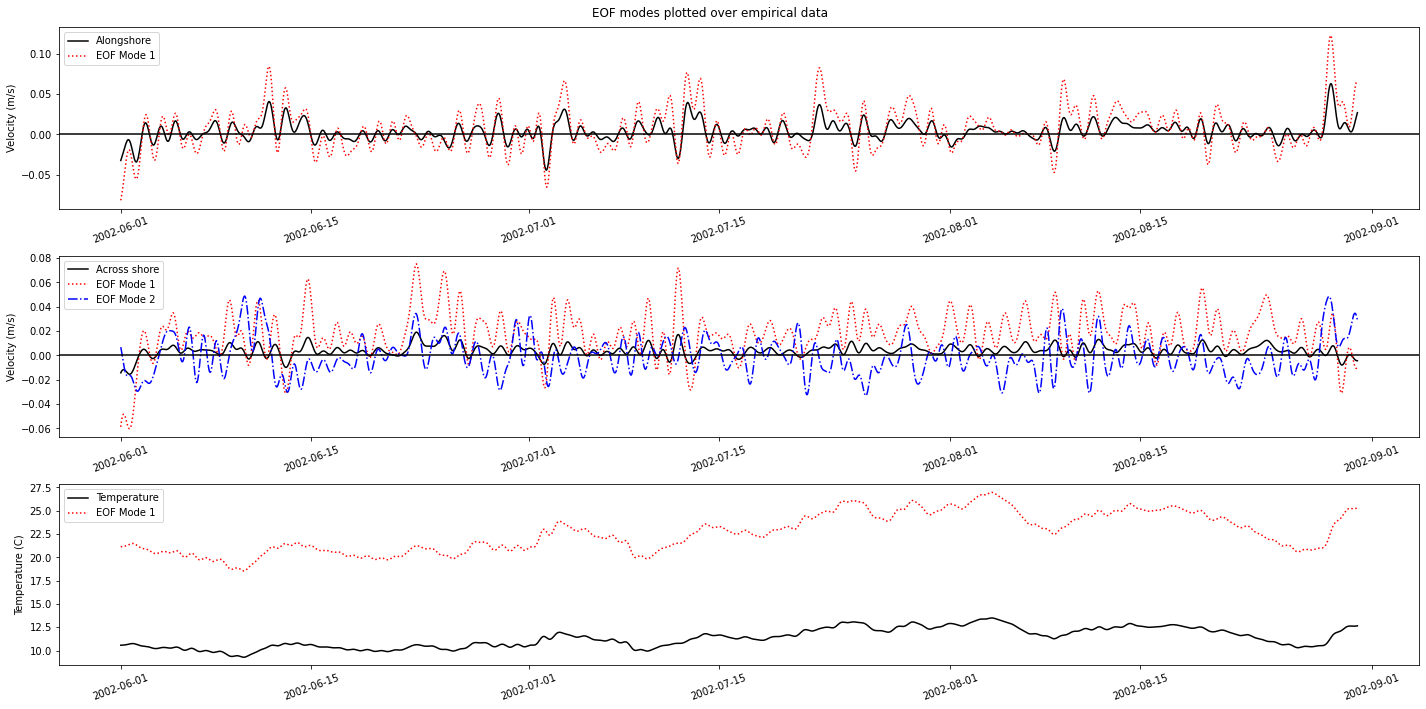

In [155]:
plt.figure(figsize = (20,10))
plt.subplot(311)
plt.plot(summer_alongshore.time, summer_alongshore.mean(axis=1), '-k')
plt.plot(summer_alongshore.time, (as_EOF_ts[:,0]+as_EOF_ts[:,1])/2, ':r')
plt.axhline(y=0, c='k')
plt.xticks(rotation=20)
plt.ylabel('Velocity (m/s)')
plt.legend(['Alongshore', 'EOF Mode 1'])

plt.subplot(312)
plt.plot(summer_crossshore.time, summer_crossshore.mean(axis=1), '-k')
plt.plot(summer_crossshore.time, cs_EOF_ts[:,0], ':r')
plt.plot(summer_crossshore.time, cs_EOF_ts[:,1], '-.b')
plt.axhline(y=0, c='k')
plt.xticks(rotation=20)
plt.ylabel('Velocity (m/s)')
plt.legend(['Across shore', 'EOF Mode 1', 'EOF Mode 2'])

plt.subplot(313)
plt.plot(summer_therm.time, summer_therm.mean(axis=1), '-k')
plt.plot(summer_therm.time, t_EOF_ts[:,0], ':r')
plt.xticks(rotation=20)
plt.ylabel('Temperature (C)')
plt.legend(['Temperature', 'EOF Mode 1'])

plt.suptitle('EOF modes plotted over empirical data')
plt.tight_layout()
plt.savefig('EOF_emp_comp.PNG')

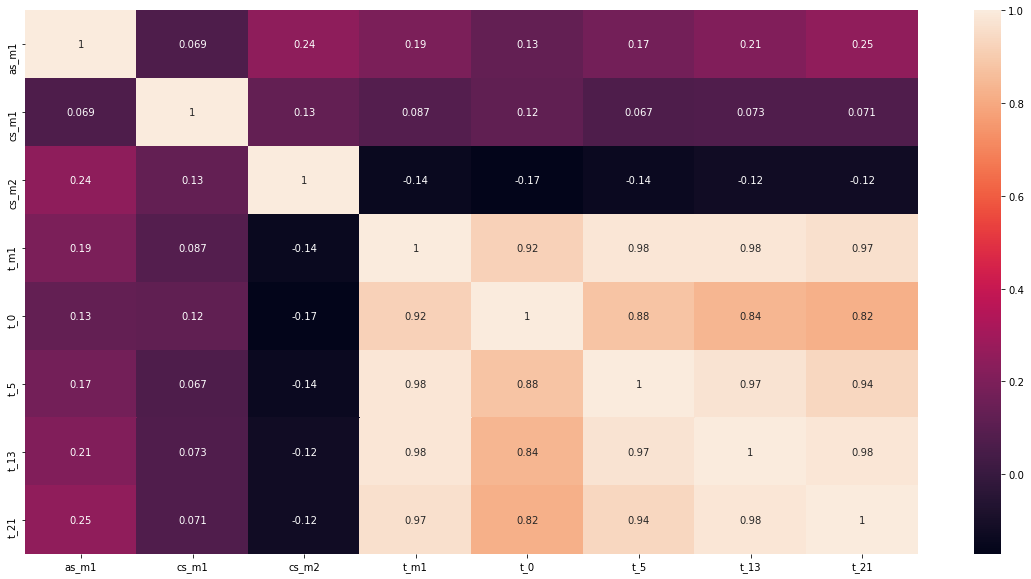

In [156]:
data_as = {'as_m1': as_EOF_ts[:,0],
        'as_m2': as_EOF_ts[:,1],
        'as_m3': as_EOF_ts[:,2],
        'as_emp': summer_alongshore.mean(axis=1)}
data_cs = {'cs_m1': cs_EOF_ts[:,0],
        'cs_m2': cs_EOF_ts[:,1],
        'cs_m3': cs_EOF_ts[:,2],
        'cs_emp': summer_crossshore.mean(axis=1)}
data_t = {'t_m1': t_EOF_ts[:,0],
        't_m2': t_EOF_ts[:,1],
        't_m3': t_EOF_ts[:,2],
        't_0': summer_therm.isel(depth=0),
        't_5': summer_therm.isel(depth=1),
        't_13': summer_therm.isel(depth=2),
        't_21': summer_therm.isel(depth=3)
        }

data_all = {'as_m1': as_EOF_ts[:,0],
        'cs_m1': cs_EOF_ts[:,0],
        'cs_m2': cs_EOF_ts[:,1],
        't_m1': t_EOF_ts[:,0],
        't_0': summer_therm.isel(depth=0),
        't_5': summer_therm.isel(depth=1),
        't_13': summer_therm.isel(depth=2),
        't_21': summer_therm.isel(depth=3)}

df_as = pd.DataFrame(data_as)
df_cs = pd.DataFrame(data_cs)
df_t = pd.DataFrame(data_t)
df_all = pd.DataFrame(data_all)

corrMatrix_as = df_as.corr()
corrMatrix_cs = df_cs.corr()
corrMatrix_t = df_t.corr()
corrMatrix_all= df_all.corr()

plt.figure(figsize=(20,10))
#plt.subplot(131)
#sn.heatmap(corrMatrix_as, annot=True)
#plt.subplot(132)
#sn.heatmap(corrMatrix_cs, annot=True)
#plt.subplot(133)
#sn.heatmap(corrMatrix_t, annot=True)
sn.heatmap(corrMatrix_all, annot=True)
plt.savefig('corr_mat.PNG')

In [139]:
as_time = np.arange(0,2184)
as_matrix = np.zeros((1,15,2184))
for i in as_time:
    as_EOF_ts = np.matmul((summer_alongshore.isel(time=i)).values, as_vec)
    as_matrix[0,:,i] = as_EOF_ts
as_matrix
#as_EOF_ts = (np.matmul(summer_alongshore.values, as_vec))

array([[[ 1.28809437e-01,  1.20391227e-01,  1.11843399e-01, ...,
         -8.32785105e-02, -9.41144469e-02, -1.04038146e-01],
        [ 3.52430297e-02,  3.60363999e-02,  3.59139316e-02, ...,
         -4.62578743e-02, -3.87037618e-02, -2.97209242e-02],
        [-2.41965312e-02, -2.62039488e-02, -2.85202686e-02, ...,
         -1.69876199e-02, -1.55314090e-02, -1.40828321e-02],
        ...,
        [-1.58477021e-04, -5.04542700e-05,  6.56386383e-05, ...,
         -1.00762666e-04, -3.09332422e-05,  3.70084519e-05],
        [-1.30274648e-04, -6.28556103e-05,  4.10791878e-06, ...,
          3.88759612e-05, -9.72912548e-05, -2.43124283e-04],
        [-1.25826639e-04, -5.94575214e-06,  1.07920346e-04, ...,
          7.68905145e-05,  9.20624389e-05,  1.13936287e-04]]])

(0.0001, 100)

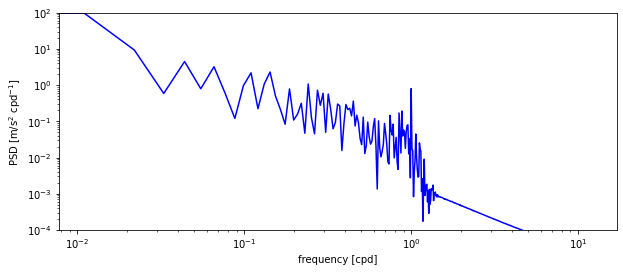

In [158]:
N = len(summer_therm.isel(depth=0))
fp,Sp = periodogram(summer_therm.isel(depth=0), 24)
plt.figure(figsize=(10,4))
plt.loglog(fp,Sp,'b')
plt.xlabel('frequency [cpd]')
plt.ylabel('PSD [m/s$^2$ cpd$^{-1}$]')
# plt.title(str(title))
plt.ylim([1E-4,100])

In [ ]:
# x = samp_freq/10
# y = upper_y/1000
# plt.plot(np.array([x,x]), y*np.array([x2_lower,x2_upper]),'k-')

# edof = 2
# x2_upper = edof/chi2.ppf(.975, edof)
# x2_lower = edof/chi2.ppf(.025, edof)
    

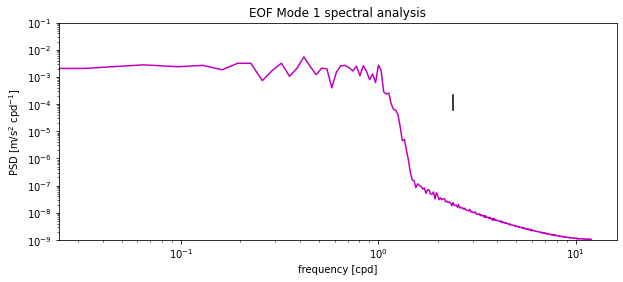

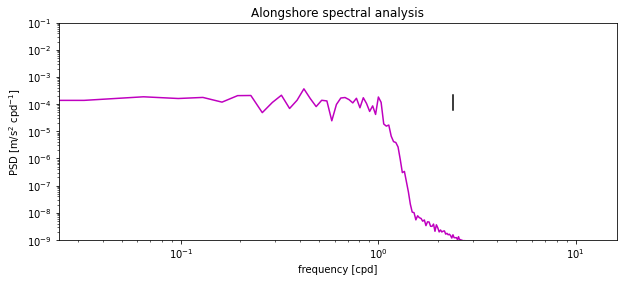

In [58]:
# as_fp, as_Sp = fpp.spec_analysis(as_EOF_ts[:,0], 24, 'hamming1', 'm/s', 'EOF Mode 1 spectral analysis', 1E-9, .1)
# as_fp, as_Sp = fpp.spec_analysis(summer_alongshore.mean(axis=1), 24, 'hamming1', 'm/s', 'Alongshore spectral analysis', 1E-9, .1)